<h1 div class='alert alert-success'><center> TPS Feb 2022 - Ponto de partida (EDA)</center></h1>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

# <div class="alert alert-success">  OBJETIVO </div> 

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados dos datasets e estabelecer uma linha de base.


---

# <div class="alert alert-success">  1. IMPORTAÇÕES </div> 

## 1.1. Instalações

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import re

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb

In [4]:
from sklearn.model_selection import train_test_split,  KFold, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer, LabelEncoder,normalize
from sklearn.impute          import SimpleImputer
from sklearn                 import metrics
from datetime                import datetime
from scipy.stats             import mode

In [5]:
from sklearn.utils.class_weight import compute_sample_weight

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [1]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]
    
    # Colors
    dark_red   = "#b20710"
    black      = "#221f1f"
    green      = "#009473"
    myred      = '#CD5C5C'
    myblue     = '#6495ED'
    mygreen    = '#90EE90'    
    color_cols = [myred, myblue,mygreen]
    
    return icecream, colors, color_cols

icecream, colors, color_cols = jupyter_setting()

NameError: name 'pd' is not defined

In [7]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [8]:
def reduce_memory_usage(df, verbose=True):
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    for col in df.columns:
        
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
        
    return df

In [9]:
def graf_feature_corr(df, annot_=False, threshold=.8, print_var=False):
    
    df = df.corr(method ='pearson').round(5)

    # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
    mask = np.zeros_like(df)
    mask[np.triu_indices_from(mask)] = True

    # Making a plot
    plt.figure(figsize=(20,12))
    ax = sns.heatmap(df, annot=annot_, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

    ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

    plt.setp(ax.get_xticklabels(), 
             rotation      = 90, 
             ha            = "right",
             rotation_mode = "anchor", 
             weight        = "normal")

    plt.setp(ax.get_yticklabels(), 
             weight        = "normal",
             rotation_mode = "anchor", 
             rotation      = 0, 
             ha            = "right");
    
    if print_var: 
        print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold))
        df_corr = df[abs(df)>threshold][df!=1.0].unstack().dropna().reset_index()
        df_corr.columns =  ['var_1', 'var_2', 'corr']
        display(df_corr)

In [10]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

In [11]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [12]:
def describe(df):
    var = df.columns

    # Medidas de tendência central, média e mediana 
    ct1 = pd.DataFrame(df[var].apply(np.mean)).T
    ct2 = pd.DataFrame(df[var].apply(np.median)).T

    # Dispensão - str, min , max range skew, kurtosis
    d1 = pd.DataFrame(df[var].apply(np.std)).T
    d2 = pd.DataFrame(df[var].apply(min)).T
    d3 = pd.DataFrame(df[var].apply(max)).T
    d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

    # concatenete 
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
    m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
    
    return m

In [13]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [14]:
def confusion_plot(matrix, labels = None, title = None):
        
    labels = labels if labels else ['Negative (0)', 'Positive (1)']    
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    sns.heatmap(data        = matrix, 
                cmap        = 'Blues', 
                annot       = True, 
                fmt         = 'd',
                xticklabels = labels, 
                yticklabels = labels, 
                ax          = ax);
    
    ax.set_xlabel('\n PREVISTO', fontsize=15)
    ax.set_ylabel('REAL \n', fontsize=15)
    ax.set_title(title)
    
    plt.close();
    
    return fig;

In [15]:
def graf_outlier(df, feature):
    col = [(0,4), (5,9)]

    df_plot = ((df[feature] - df[feature].min())/
               (df[feature].max() - df[feature].min()))

    fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

    for i, (x) in enumerate(col): 
        sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

In [16]:
def graf_eval():

    results     = model.evals_result()
    ntree_limit = model.best_ntree_limit

    plt.figure(figsize=(20,7))

    for i, error in  enumerate(['mlogloss', 'merror']):#
        
        plt.subplot(1,2,i+1)
        plt.plot(results["validation_0"][error], label="Treinamento")
        plt.plot(results["validation_1"][error], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))
                    
        
        title_name ='\n' + error.upper() + ' PLOT \n'
        plt.title(title_name)
        plt.xlabel("Número de árvores")
        plt.ylabel(error)
        plt.legend();

## 1.4. Dataset

### 1.4.1. Descrição de dados

O dataset disponibilizado pelo kaggle, tem a finalidade de prever as espécies de bacterias com base em repetidas medições com fragmentos de DNA, os dados foram coletados com espectrocopia de Raman que calcula o histograma de base ATATGGCCTT no trecho A2T4G2C2. 

Cada linha de dados contém um espectro de histogramas gerados por medições repetidas de uma amostra, cada linha contendo a saída de todas as 286 possibilidades de histograma.

Os dados (tanto de treinamento quanto de teste) também contêm erros de medição simulados (taxas variadas) para muitas das amostras, o que torna o problema mais desafiador.

### 1.4.2. Variável de alvo
A meta para a competição deste mês é uma variável multiclasse, temos 10 classes que são:

- Streptococcus_pyogenes,
- Salmonella_enterica,
- Enterococcus_hirar,
- Escherichia_coli
- Campylobacter_jejuni
- Streptococcus_pneumoniae
- Staphylococcus_aureus'
- Escherichia_fergusonii'
- Bacteroides_fragilis'
- Klebsiella_pneumoniae



### 1.4.3. Arquivos
- **train.csv** - o conjunto de treinamento
- **test.csv** - o conjunto de teste; a tarefa é prever as espécies de bactérias (target) para cada row_id
- **sample_submission.csv** - um arquivo de envio de amostra no formato correto


### 1.4.4. Estrutura de pasta

In [17]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
         'model', 'model/preds', 'model/optuna','model/preds/test', 
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param']

for path in paths:
    try:
        os.mkdir(path)       
    except:
        pass  

### 1.4.5. Carrega dados

In [18]:
path      = '/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/02 - Fevereiro/'
path     = '../input/tabular-playground-series-feb-2022/'
path_data = ''  
target    = 'target'

In [19]:
df1_train     = pd.read_csv(path + path_data + 'train.csv')
df1_test      = pd.read_csv(path + path_data + 'test.csv')
df_submission = pd.read_csv(path + path_data + 'sample_submission.csv')

df1_train.drop('row_id', axis=1, inplace=True)
df1_test.drop('row_id', axis=1, inplace=True)

df1_train.shape, df1_test.shape, df_submission.shape

((200000, 287), (100000, 286), (100000, 2))

In [20]:
df1_train.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,A0T0G10C0,A0T1G0C9,A0T1G1C8,A0T1G2C7,A0T1G3C6,A0T1G4C5,A0T1G5C4,A0T1G6C3,A0T1G7C2,A0T1G8C1,A0T1G9C0,A0T2G0C8,A0T2G1C7,A0T2G2C6,A0T2G3C5,A0T2G4C4,A0T2G5C3,A0T2G6C2,A0T2G7C1,A0T2G8C0,A0T3G0C7,A0T3G1C6,A0T3G2C5,A0T3G3C4,A0T3G4C3,A0T3G5C2,A0T3G6C1,A0T3G7C0,A0T4G0C6,A0T4G1C5,A0T4G2C4,A0T4G3C3,A0T4G4C2,A0T4G5C1,A0T4G6C0,A0T5G0C5,A0T5G1C4,A0T5G2C3,A0T5G3C2,A0T5G4C1,A0T5G5C0,A0T6G0C4,A0T6G1C3,A0T6G2C2,A0T6G3C1,A0T6G4C0,A0T7G0C3,A0T7G1C2,A0T7G2C1,A0T7G3C0,A0T8G0C2,A0T8G1C1,A0T8G2C0,A0T9G0C1,A0T9G1C0,A0T10G0C0,A1T0G0C9,A1T0G1C8,A1T0G2C7,A1T0G3C6,A1T0G4C5,A1T0G5C4,A1T0G6C3,A1T0G7C2,A1T0G8C1,A1T0G9C0,A1T1G0C8,A1T1G1C7,A1T1G2C6,A1T1G3C5,A1T1G4C4,A1T1G5C3,A1T1G6C2,A1T1G7C1,A1T1G8C0,A1T2G0C7,A1T2G1C6,A1T2G2C5,A1T2G3C4,A1T2G4C3,A1T2G5C2,A1T2G6C1,A1T2G7C0,A1T3G0C6,A1T3G1C5,A1T3G2C4,A1T3G3C3,A1T3G4C2,A1T3G5C1,A1T3G6C0,A1T4G0C5,A1T4G1C4,A1T4G2C3,A1T4G3C2,A1T4G4C1,A1T4G5C0,A1T5G0C4,A1T5G1C3,A1T5G2C2,A1T5G3C1,A1T5G4C0,A1T6G0C3,A1T6G1C2,A1T6G2C1,A1T6G3C0,A1T7G0C2,A1T7G1C1,A1T7G2C0,A1T8G0C1,A1T8G1C0,A1T9G0C0,A2T0G0C8,A2T0G1C7,A2T0G2C6,A2T0G3C5,A2T0G4C4,A2T0G5C3,A2T0G6C2,A2T0G7C1,A2T0G8C0,A2T1G0C7,A2T1G1C6,A2T1G2C5,A2T1G3C4,A2T1G4C3,A2T1G5C2,A2T1G6C1,A2T1G7C0,A2T2G0C6,A2T2G1C5,A2T2G2C4,A2T2G3C3,A2T2G4C2,A2T2G5C1,A2T2G6C0,A2T3G0C5,A2T3G1C4,A2T3G2C3,A2T3G3C2,A2T3G4C1,A2T3G5C0,A2T4G0C4,A2T4G1C3,A2T4G2C2,A2T4G3C1,A2T4G4C0,A2T5G0C3,A2T5G1C2,A2T5G2C1,A2T5G3C0,A2T6G0C2,A2T6G1C1,A2T6G2C0,A2T7G0C1,A2T7G1C0,A2T8G0C0,A3T0G0C7,A3T0G1C6,A3T0G2C5,A3T0G3C4,A3T0G4C3,A3T0G5C2,A3T0G6C1,A3T0G7C0,A3T1G0C6,A3T1G1C5,A3T1G2C4,A3T1G3C3,A3T1G4C2,A3T1G5C1,A3T1G6C0,A3T2G0C5,A3T2G1C4,A3T2G2C3,A3T2G3C2,A3T2G4C1,A3T2G5C0,A3T3G0C4,A3T3G1C3,A3T3G2C2,A3T3G3C1,A3T3G4C0,A3T4G0C3,A3T4G1C2,A3T4G2C1,A3T4G3C0,A3T5G0C2,A3T5G1C1,A3T5G2C0,A3T6G0C1,A3T6G1C0,A3T7G0C0,A4T0G0C6,A4T0G1C5,A4T0G2C4,A4T0G3C3,A4T0G4C2,A4T0G5C1,A4T0G6C0,A4T1G0C5,A4T1G1C4,A4T1G2C3,A4T1G3C2,A4T1G4C1,A4T1G5C0,A4T2G0C4,A4T2G1C3,A4T2G2C2,A4T2G3C1,A4T2G4C0,A4T3G0C3,A4T3G1C2,A4T3G2C1,A4T3G3C0,A4T4G0C2,A4T4G1C1,A4T4G2C0,A4T5G0C1,A4T5G1C0,A4T6G0C0,A5T0G0C5,A5T0G1C4,A5T0G2C3,A5T0G3C2,A5T0G4C1,A5T0G5C0,A5T1G0C4,A5T1G1C3,A5T1G2C2,A5T1G3C1,A5T1G4C0,A5T2G0C3,A5T2G1C2,A5T2G2C1,A5T2G3C0,A5T3G0C2,A5T3G1C1,A5T3G2C0,A5T4G0C1,A5T4G1C0,A5T5G0C0,A6T0G0C4,A6T0G1C3,A6T0G2C2,A6T0G3C1,A6T0G4C0,A6T1G0C3,A6T1G1C2,A6T1G2C1,A6T1G3C0,A6T2G0C2,A6T2G1C1,A6T2G2C0,A6T3G0C1,A6T3G1C0,A6T4G0C0,A7T0G0C3,A7T0G1C2,A7T0G2C1,A7T0G3C0,A7T1G0C2,A7T1G1C1,A7T1G2C0,A7T2G0C1,A7T2G1C0,A7T3G0C0,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,-9.536743e-07,-0.000010,-8.583069e-05,-0.000343,-0.000801,-0.001202,-0.001202,-0.000801,-0.000343,-0.000086,-0.000010,-4.291534e-05,-0.000343,-0.001202,-0.002403,-0.003004,-0.002403,-0.001202,-0.000343,-0.000043,-0.000114,-0.000801,-0.002403,-0.004005,-0.004005,-0.002403,-0.000801,-0.000114,-0.000200,-0.001202,-0.003004,-0.004005,-0.003004,-0.001202,-0.000200,-0.000240,-0.001202,-0.002403,-0.002403,-0.001202,-0.000240,-0.000200,-0.000801,-0.001202,-0.000801,-0.000200,-0.000114,-0.000343,-0.000343,-0.000114,-0.000043,-0.000086,-0.000043,-0.000010,-0.000010,-9.536743e-07,-9.536743e-06,-0.000086,-0.000343,-0.000801,-0.001202,-0.001202,-0.000801,-0.000343,-0.000086,-0.000010,-0.000086,-0.000687,-0.002403,-0.004807,-0.006008,-0.004807,-0.002403,-0.000687,-0.000086,-0.000343,-0.002403,-0.007210,-0.002016,-0.012016,-0.007210,0.017597,0.009657,-0.000801,-0.004807,0.007984,-0.006022,0.007984,-0.004807,-0.000801,-0.001202,0.003992,-0.012016,-0.012016,0.003992,0.008798,-0.001202,-0.004807,0.002790,-0.004807,-0.001202,-0.000801,0.007597,0.007597,-0.000801,-0.000343,-0.000687,-0.000343,-0.000086,-0.000086,-0.000010,-0.000043,-0.000343,-0.001202,-0.002403,-0.003004,-0.002403,-0.001202,-0.000343,-0.000043,-0.000343,-0.002403,-0.007210,-0.012016,-0.002016,-0.007210,-0.002403,-0.000343,0.008798,-0.007210

In [21]:
df1_test.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,A0T0G10C0,A0T1G0C9,A0T1G1C8,A0T1G2C7,A0T1G3C6,A0T1G4C5,A0T1G5C4,A0T1G6C3,A0T1G7C2,A0T1G8C1,A0T1G9C0,A0T2G0C8,A0T2G1C7,A0T2G2C6,A0T2G3C5,A0T2G4C4,A0T2G5C3,A0T2G6C2,A0T2G7C1,A0T2G8C0,A0T3G0C7,A0T3G1C6,A0T3G2C5,A0T3G3C4,A0T3G4C3,A0T3G5C2,A0T3G6C1,A0T3G7C0,A0T4G0C6,A0T4G1C5,A0T4G2C4,A0T4G3C3,A0T4G4C2,A0T4G5C1,A0T4G6C0,A0T5G0C5,A0T5G1C4,A0T5G2C3,A0T5G3C2,A0T5G4C1,A0T5G5C0,A0T6G0C4,A0T6G1C3,A0T6G2C2,A0T6G3C1,A0T6G4C0,A0T7G0C3,A0T7G1C2,A0T7G2C1,A0T7G3C0,A0T8G0C2,A0T8G1C1,A0T8G2C0,A0T9G0C1,A0T9G1C0,A0T10G0C0,A1T0G0C9,A1T0G1C8,A1T0G2C7,A1T0G3C6,A1T0G4C5,A1T0G5C4,A1T0G6C3,A1T0G7C2,A1T0G8C1,A1T0G9C0,A1T1G0C8,A1T1G1C7,A1T1G2C6,A1T1G3C5,A1T1G4C4,A1T1G5C3,A1T1G6C2,A1T1G7C1,A1T1G8C0,A1T2G0C7,A1T2G1C6,A1T2G2C5,A1T2G3C4,A1T2G4C3,A1T2G5C2,A1T2G6C1,A1T2G7C0,A1T3G0C6,A1T3G1C5,A1T3G2C4,A1T3G3C3,A1T3G4C2,A1T3G5C1,A1T3G6C0,A1T4G0C5,A1T4G1C4,A1T4G2C3,A1T4G3C2,A1T4G4C1,A1T4G5C0,A1T5G0C4,A1T5G1C3,A1T5G2C2,A1T5G3C1,A1T5G4C0,A1T6G0C3,A1T6G1C2,A1T6G2C1,A1T6G3C0,A1T7G0C2,A1T7G1C1,A1T7G2C0,A1T8G0C1,A1T8G1C0,A1T9G0C0,A2T0G0C8,A2T0G1C7,A2T0G2C6,A2T0G3C5,A2T0G4C4,A2T0G5C3,A2T0G6C2,A2T0G7C1,A2T0G8C0,A2T1G0C7,A2T1G1C6,A2T1G2C5,A2T1G3C4,A2T1G4C3,A2T1G5C2,A2T1G6C1,A2T1G7C0,A2T2G0C6,A2T2G1C5,A2T2G2C4,A2T2G3C3,A2T2G4C2,A2T2G5C1,A2T2G6C0,A2T3G0C5,A2T3G1C4,A2T3G2C3,A2T3G3C2,A2T3G4C1,A2T3G5C0,A2T4G0C4,A2T4G1C3,A2T4G2C2,A2T4G3C1,A2T4G4C0,A2T5G0C3,A2T5G1C2,A2T5G2C1,A2T5G3C0,A2T6G0C2,A2T6G1C1,A2T6G2C0,A2T7G0C1,A2T7G1C0,A2T8G0C0,A3T0G0C7,A3T0G1C6,A3T0G2C5,A3T0G3C4,A3T0G4C3,A3T0G5C2,A3T0G6C1,A3T0G7C0,A3T1G0C6,A3T1G1C5,A3T1G2C4,A3T1G3C3,A3T1G4C2,A3T1G5C1,A3T1G6C0,A3T2G0C5,A3T2G1C4,A3T2G2C3,A3T2G3C2,A3T2G4C1,A3T2G5C0,A3T3G0C4,A3T3G1C3,A3T3G2C2,A3T3G3C1,A3T3G4C0,A3T4G0C3,A3T4G1C2,A3T4G2C1,A3T4G3C0,A3T5G0C2,A3T5G1C1,A3T5G2C0,A3T6G0C1,A3T6G1C0,A3T7G0C0,A4T0G0C6,A4T0G1C5,A4T0G2C4,A4T0G3C3,A4T0G4C2,A4T0G5C1,A4T0G6C0,A4T1G0C5,A4T1G1C4,A4T1G2C3,A4T1G3C2,A4T1G4C1,A4T1G5C0,A4T2G0C4,A4T2G1C3,A4T2G2C2,A4T2G3C1,A4T2G4C0,A4T3G0C3,A4T3G1C2,A4T3G2C1,A4T3G3C0,A4T4G0C2,A4T4G1C1,A4T4G2C0,A4T5G0C1,A4T5G1C0,A4T6G0C0,A5T0G0C5,A5T0G1C4,A5T0G2C3,A5T0G3C2,A5T0G4C1,A5T0G5C0,A5T1G0C4,A5T1G1C3,A5T1G2C2,A5T1G3C1,A5T1G4C0,A5T2G0C3,A5T2G1C2,A5T2G2C1,A5T2G3C0,A5T3G0C2,A5T3G1C1,A5T3G2C0,A5T4G0C1,A5T4G1C0,A5T5G0C0,A6T0G0C4,A6T0G1C3,A6T0G2C2,A6T0G3C1,A6T0G4C0,A6T1G0C3,A6T1G1C2,A6T1G2C1,A6T1G3C0,A6T2G0C2,A6T2G1C1,A6T2G2C0,A6T3G0C1,A6T3G1C0,A6T4G0C0,A7T0G0C3,A7T0G1C2,A7T0G2C1,A7T0G3C0,A7T1G0C2,A7T1G1C1,A7T1G2C0,A7T2G0C1,A7T2G1C0,A7T3G0C0,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
0,-9.536743e-07,-0.000002,-9.153442e-07,0.000024,0.000034,-0.000002,0.000021,0.000024,-0.000009,-0.000008,-9.536743e-07,-0.000003,-0.000017,-0.000074,0.000038,0.000068,0.000164,0.000180,-0.000003,-0.000025,-0.000009,0.000004,-0.000101,-0.000171,0.000006,0.000330,0.000580,0.000228,-0.000015,-0.000016,-0.000026,-0.000146,-0.000075,0.000212,0.000565,0.000359,0.000072,-0.000005,-0.000043,-0.000110,0.000061,0.000349,0.000338,0.000163,-0.000003,0.000005,0.000050,0.000332,0.000447,0.000212,0.000016,0.000031,0.000196,0.000331,0.000261,0.000035,0.000064,0.000202,0.000175,0.000047,0.000031,0.000104,0.000026,0.000012,0.000009,-9.536743e-07,4.632568e-07,-0.000016,-0.000005,0.000141,0.000170,0.000091,0.000076,-0.000062,-0.000026,-0.000005,-0.000019,-0.000179,-0.000068,0.000362,0.000505,0.000449,-0.000047,-0.000148,-0.000027,-0.000092,-0.000457,-0.000095,0.000379,0.000940,0.000355,-0.000236,-0.000087,-0.000180,-0.000496,-0.000106,0.000351,0.000539,-0.000045,-0.000107,-0.000103,-0.000306,0.000241,0.000404,0.000074,-0.000065,0.000071,0.000282,0.000549,0.000418,0.000001,0.000214,0.000584,0.000592,0.000200,0.000193,0.000354,0.000146,0.000102,0.000091,0.000024,-0.000011,-0.000030,0.000263,0.000496,0.000333,0.000038,-0.000180,-0.000093,-0.000009,-0.000086,-0.000142,0.000172,0.000703,0.000237,-0.000323,-0.000412,-0.000083,-0.000231,-0.000618,-0.000275,-0.000510,-0.000272,-0.000569,-0.000264,-0.000420,-0.000990,-0.00106

### 1.4.6. Redução dos datasets

In [22]:
df1_train = reduce_memory_usage(df1_train)
df1_test  = reduce_memory_usage(df1_test)

Mem. usage decreased to 110.63 Mb (74.7% reduction)
Mem. usage decreased to 54.55 Mb (75.0% reduction)


<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
Tivemos uma redução de aproximadamente de 75% em ambos os datasets.
    
</div>

# <div class="alert alert-success"> 2. Análise Exploratória de Dados (EDA)  </div> 

## 2.1. Dimensão do DataSet

In [23]:
print('TREINO')
print('Number of Rows: {}'.format(df1_train.shape[0]))
print('Number of Columns: {}'.format(df1_train.shape[1]), end='\n\n')

print('TESTE')
print('Number of Rows: {}'.format(df1_test.shape[0]))
print('Number of Columns: {}'.format(df1_test.shape[1]))

TREINO
Number of Rows: 200000
Number of Columns: 287

TESTE
Number of Rows: 100000
Number of Columns: 286


## 2.2. Tipo de dados

In [24]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 287 entries, A0T0G0C10 to target
dtypes: float16(286), object(1)
memory usage: 110.6+ MB


In [25]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 287 entries, A0T0G0C10 to target
dtypes: float16(286), object(1)
memory usage: 110.6+ MB


In [26]:
print(f'{3*"="} For Pandas {10*"="}\n{(df1_train.dtypes).value_counts()}')
print(f'\n{3*"="} For Datatable {7*"="}\n{(df1_test.dtypes).value_counts()}')

=== For Pandas ==========
float16    286
object       1
dtype: int64

=== For Datatable =======
float16    286
dtype: int64


## 2.3. Identificar NA

In [27]:
missing = missing_zero_values_table(df1_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 287 colunas e 200000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


In [28]:
missing = missing_zero_values_table(df1_test)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 286 colunas e 100000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>

Não temos dados faltantes.
    
</div>

## 2.4 Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

In [29]:
feature_float = []
feature_cat   = df1_test.select_dtypes(object).columns

for col in df1_test.columns:
    if col not in feature_cat: 
        feature_float.append(col)   

feature_float_test = feature_float.copy()

msg = 'Temos {} variávies numéricas e {} categóricas.'
print(msg.format(len(feature_float), len(feature_cat)))

Temos 286 variávies numéricas e 0 categóricas.


### 2.4.1 Atributos numéricos

- Train

In [30]:
df1_train[feature_float].describe().style.background_gradient(cmap='YlOrRd')

- Test

In [31]:
df1_test[feature_float_test].describe().style.background_gradient(cmap='YlOrRd')

### 2.4.2. Atributos categóricos

In [32]:
df1_train[feature_cat].columns

Index([], dtype='object')

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
    
</div> 

## 2.5. Correlação
Vamos examinar a correlação entre as variáveis.

Variáveis autocorrelacionadas threshold=0.75


,var_1,var_2,corr
0,A1T2G6C1,A1T2G7C0,0.80994
1,A1T2G7C0,A1T2G6C1,0.80994
2,A3T0G3C4,A3T0G5C2,0.76486
3,A3T0G3C4,A3T1G3C3,0.80765
4,A3T0G5C2,A3T0G3C4,0.76486
5,A3T0G5C2,A3T1G3C3,0.75740
6,A3T1G3C3,A3T0G3C4,0.80765
7,A3T1G3C3,A3T0G5C2,0.75740
8,A3T4G3C0,A4T0G1C5,0.75841
9,A4T0G1C5,A3T4G3C0,0.75841


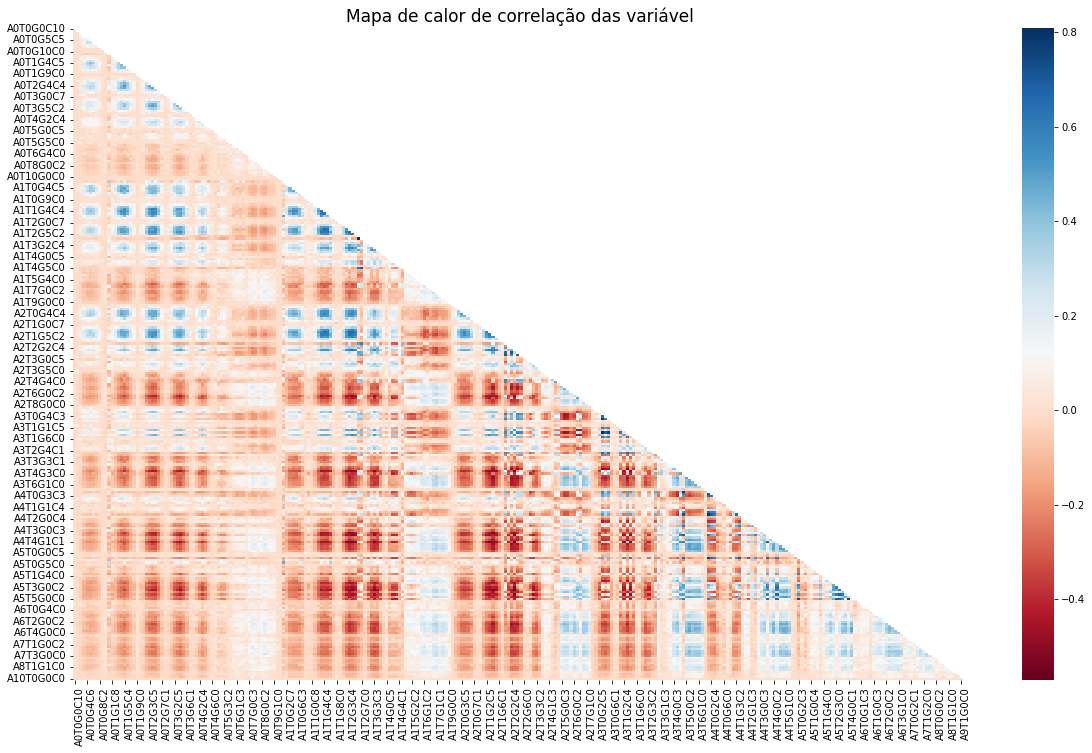

In [33]:
graf_feature_corr(df=df1_train, annot_=False, threshold=.75, print_var=True)

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Como podemos observar, a correlação fica entre -0.4 e 0.80%, é um indicativo que temos variávies com alta correlação, neste caso temos 12 variáveis com correlação acima de 75%, na modelagem podemos fazer a exclusão de algumas dessas variáveis autocorrelacionadas.  
    
</div>

## 2.6. Distribuição

### 2.6.1. Train / Test

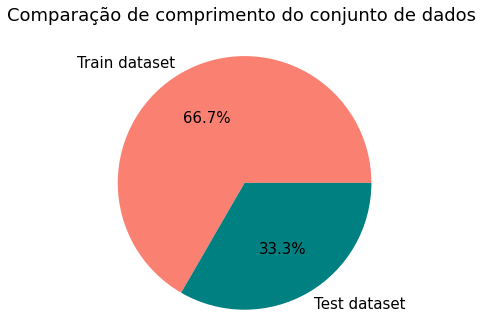

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df1_train), len(df1_test)],
             labels   = ["Train dataset", "Test dataset"],
             colors   = ["salmon", "teal"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

### 2.6.2. Proporção de variáveis

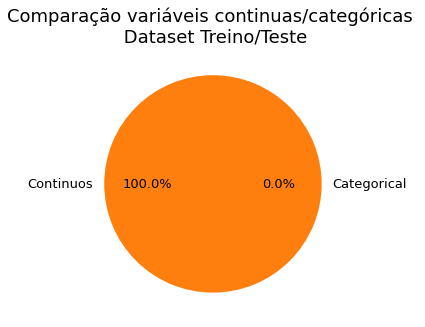

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.pie([ len(feature_cat), len(feature_float)], 
        labels=['Categorical', 'Continuos' ],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')

#ax.axis("equal")
ax.set_title("Comparação variáveis continuas/categóricas \n Dataset Treino/Teste", fontsize=18)
fig.set_facecolor('white')
plt.show()

### 2.6.3. Variável predidora

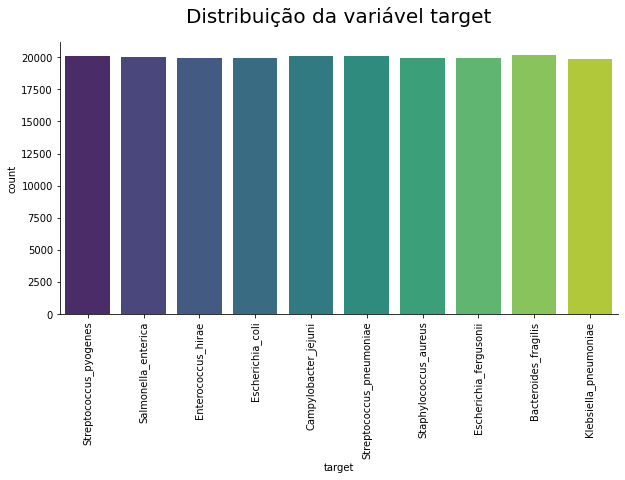

In [36]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=df1_train[target], palette='viridis')
ax.set_title('Distribuição da variável ' + target, fontsize=20, y=1.05)
ax.set_xticklabels(df1_train[target].unique(), rotation=90)
sns.despine(right=True)

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
A análise do alvo não é particularmente reveladora,  por se tratar de um experimento, temos uma distribuição de alvos bastante equilibrada.
    
    
</div>

In [37]:
stat = pd.DataFrame(df1_train[target].value_counts())
stat['percent_type'] = stat[target] / stat[target].sum()

stat.style.bar(subset=["percent_type"], color='yellow').format('{:.2%}', subset=["percent_type"])

,target,percent_type
Bacteroides_fragilis,20139,10.07%
Streptococcus_pyogenes,20076,10.04%
Streptococcus_pneumoniae,20074,10.04%
Campylobacter_jejuni,20063,10.03%
Salmonella_enterica,20030,10.02%
Escherichia_coli,19958,9.98%
Enterococcus_hirae,19947,9.97%
Escherichia_fergusonii,19937,9.97%
Staphylococcus_aureus,19929,9.96%
Klebsiella_pneumoniae,19847,9.92%


### 2.6.4. Distribuição 

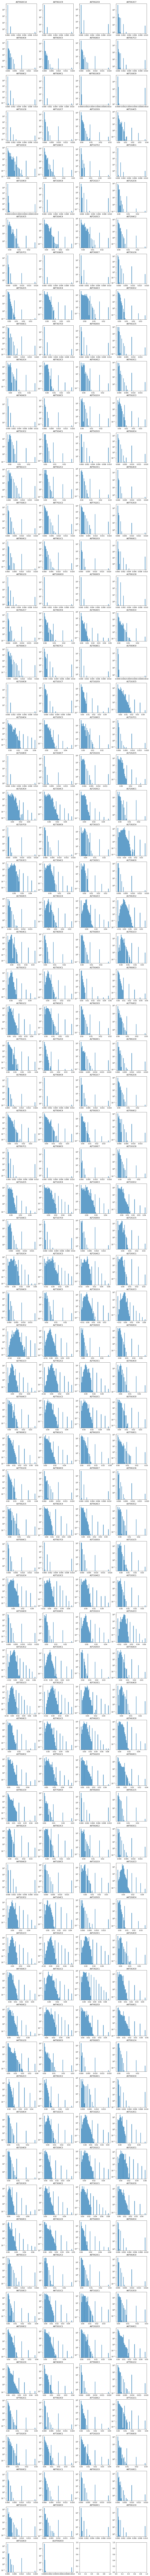

In [38]:
fig, axs = plt.subplots(72, 4, figsize=(16,300))
           
for i, col in enumerate(feature_float):
    ax = axs.flat[i]
    ax.hist(np.log1p(df1_train[col]), bins=50, density=1, alpha=0.7, log=True)
    ax.set_title(col)       

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
   
Podemos observar no gráfico acima, que os dados são muitos distorcidos, existem 286 histogramas,  vamos explorar melhor como eles estão distribuídos porque se pensarmos em todas as combinações possíveis de histogramas de ATGC com valores que variam de 0 a 11 o número deveria ter sido bem maior, cerca de 14641 histogramas. Os histogramas devem ser alguns selecionados por alguns critérios específicos. 
    
<br>

Primeiro vamos preparar uma maneira de converte as colunas em uma distribuição ATGC.    

<br>
**Referencia do código abaixo**: https://www.kaggle.com/lucamassaron/basic-eda-and-model-to-start, [@lucamassaron](https://www.kaggle.com/lucamassaron) 
    
</div>

In [39]:
def split_feature(st):
    counts = list(map(int, re.split('A|T|G|C', st)[1:]))
    return counts

feature_atgc = {c: split_feature(c) for c in feature_float}

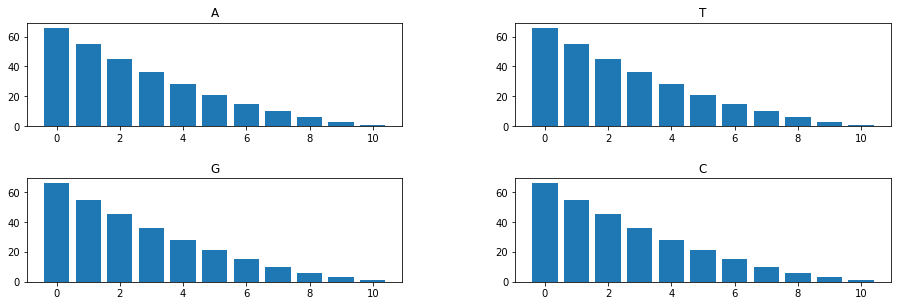

In [40]:
# Referencia: https://www.kaggle.com/lucamassaron/basic-eda-and-model-to-start, @lucamassaron
a = [0 for i in range(11)]
t = [0 for i in range(11)]
g = [0 for i in range(11)]
c = [0 for i in range(11)]

grf_list = []

for feat in feature_float:
    xa, xt, xg, xc = feature_atgc[feat]
    a[xa] += 1
    t[xt] += 1
    g[xt] += 1
    c[xc] += 1

grf_list.append(a)
grf_list.append(t)
grf_list.append(g)
grf_list.append(c)

plt.figure(figsize=(20, 3))

for i , f in enumerate(['A','T','G','C']):
    plt.subplot(2, 2, i+1)
    plt.title(f)
    plt.bar(range(11), height=a)
    
plt.subplots_adjust(left    = 0.1,
                    bottom  = 0.1, 
                    right   = 0.7, 
                    top     = 1.3, 
                    wspace  = 0.3, 
                    hspace  = 0.5
                   )

plt.show()

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
  
Nos gráficos acima, observamos claramente que a distribuição é desequilibrada, a qual não identificamos no primeiro gráfico, mas é igualmente para todas as letras, contagens mais baixas são mais frequentes do que as mais altas e a diminuição se ajusta a uma transformação de raiz quadrada.  
  
<br>
    
**OBSERVAÇÃO:** <br>
    
O espaço potencial para uma análise usando uma matriz multidimensional de 11x11x11x11 realmente não faz sentido porque você criaria uma estrutura de dados enorme para cada exemplo que tornaria muito esparsa, sendo assim,  tenho mais duas duas perguntas que tentarei responder:
    
<br>   
- existe uma maneira de representar o espaço dos histogramas melhor do que a forma proposta pela competição que poderia ser explorada pelo deep learning? (como uma sequência ou como um gráfico talvez) <br>

- Precisamos de todos os histogramas medidos? Não podemos fazer com muito menos?
    
<br>    
Vamos tentar visualizar cada alvo (target) que tem distribuição com cada variável, o gráfico pode não ser muito informativo por causa de muitas barras plotadas e podem apresentar possíveis dificuldades, pois esperamos que cada alvo tenha uma forma distinta, parcialmente mascarada pelo ruído de medição.
    
</div>

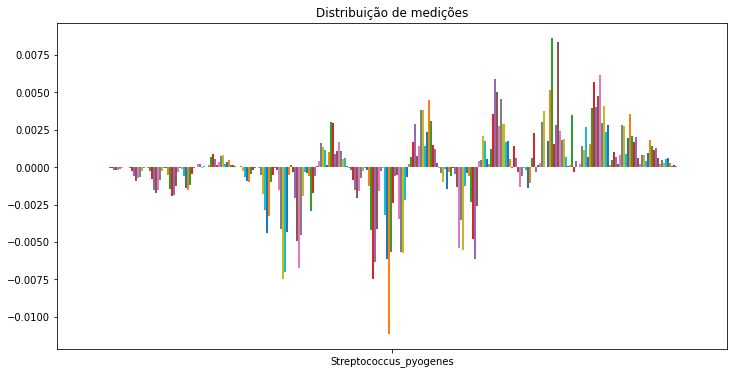

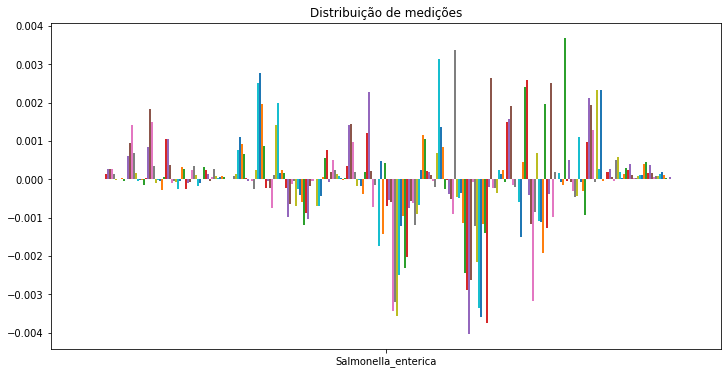

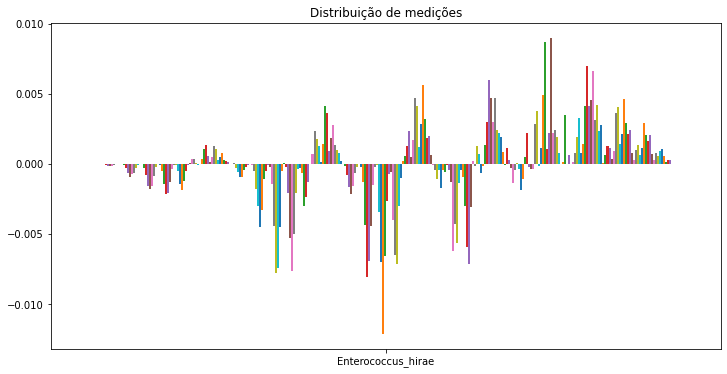

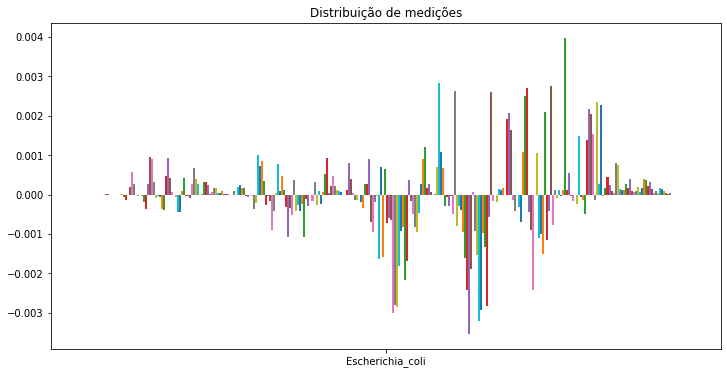

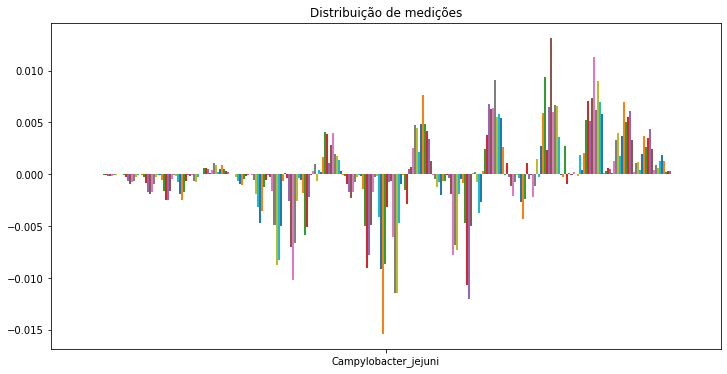

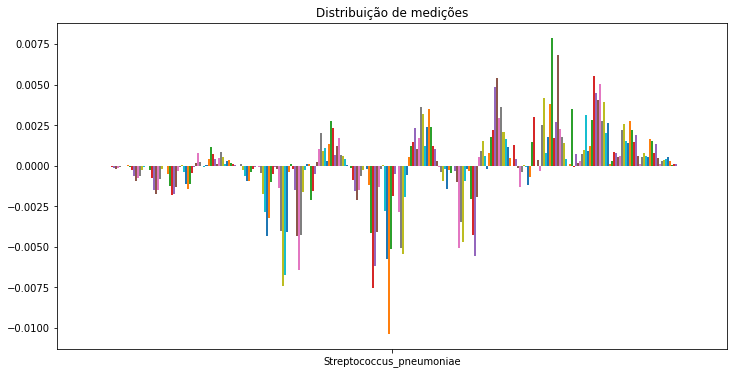

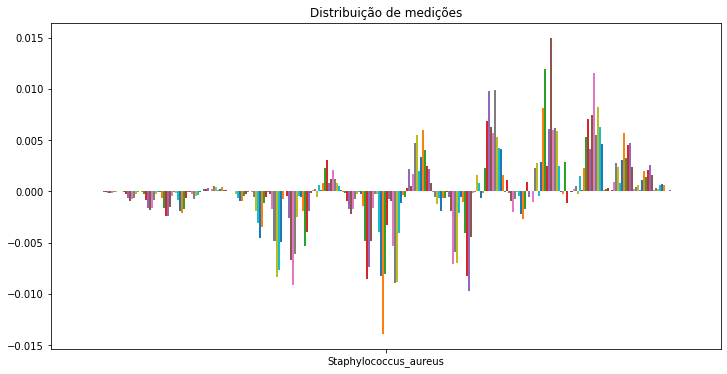

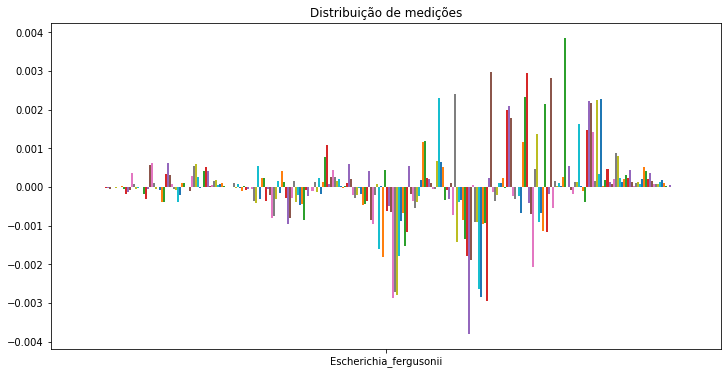

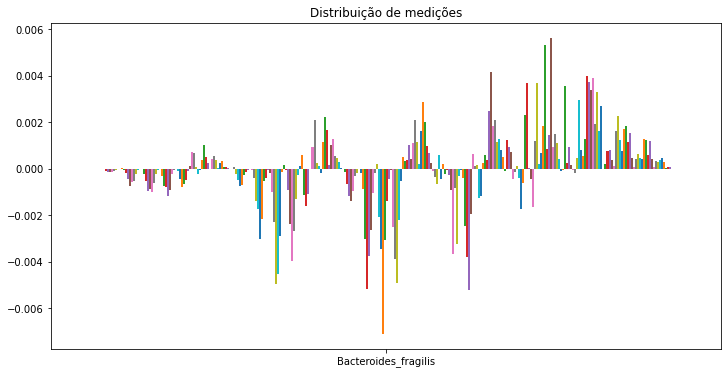

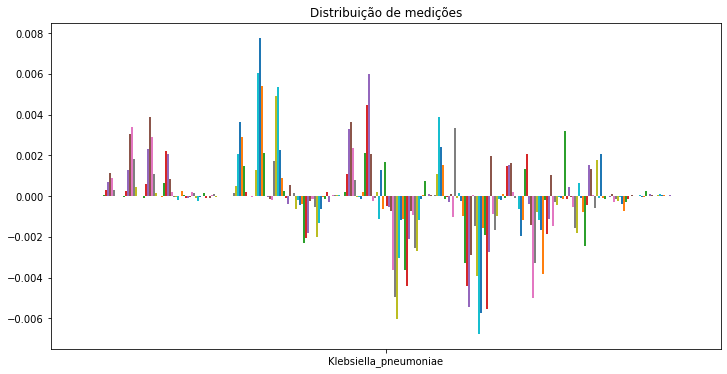

In [41]:
# Referencia: https://www.kaggle.com/lucamassaron/basic-eda-and-model-to-start, @lucamassaron

df_freqs = df1_train.groupby('target').mean()

for tgt in df1_train.target.unique():
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    df_freqs[df_freqs.index==tgt].plot.bar(ax=ax, width=3, xlabel='')    
    _lg = ax.get_legend()
    _lg.remove()
    plt.xticks(rotation = 0)
    plt.title('Distribuição de medições')
    plt.show()

# <div class="alert alert-success"> 3. Modelagem (baseline) </div> 

## 3.1. Split Train/Test

In [42]:
%%time
lb = LabelEncoder()

X      = df1_train.drop([target], axis=1)
y      = pd.DataFrame(lb.fit_transform(df1_train[target]), columns=[target])
X_test = df1_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.3,
                                                      shuffle      = True, 
                                                      stratify     = y, 
                                                      random_state = 12359)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

CPU times: user 1.54 s, sys: 211 ms, total: 1.75 s
Wall time: 1.75 s


((140000, 286), (140000, 1), (60000, 286), (60000, 1), (100000, 286))

## 3.2. Parametros do modelo

In [43]:
seed   = 12359
params = {"objective"     : 'multi:softmax',    
          'eval_metric'   : 'mlogloss',         
          'random_state'  : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
params

{'objective': 'multi:softmax',
 'eval_metric': 'mlogloss',
 'random_state': 12359,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

## 3.3. Seleção de Scaler

In [44]:
%%time 

model_baseline = xgb.XGBClassifier(**params)

scalers = [None, 
           StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)
           ]

for scaler in scalers: 
    
    if scaler!=None:
        X_train_s = scaler.fit_transform(X_train)
        X_valid_s = scaler.transform(X_valid)
    else:
        X_train_s = X_train
        X_valid_s = X_valid
                
    model_baseline.fit(X_train_s, y_train, verbose=False)

    y_pred = model_baseline.predict(X_valid_s)  
    acc    = metrics.accuracy_score(y_valid, y_pred)    
        
    print('Validaçao ACC: {:2.5f} => {}'.format(acc, scaler))

    free_gpu_cache()

print()

Validaçao ACC: 0.98182 => None
Validaçao ACC: 0.98258 => StandardScaler()
Validaçao ACC: 0.98200 => RobustScaler()
Validaçao ACC: 0.98250 => MinMaxScaler()
Validaçao ACC: 0.98245 => MaxAbsScaler()
Validaçao ACC: 0.98225 => QuantileTransformer(output_distribution='normal', random_state=0)

CPU times: user 2min 9s, sys: 2.43 s, total: 2min 11s
Wall time: 2min 10s


Vamos fazer a predição em todos os dados e gerar os aquivos de submissões para cada scaler:

In [45]:
%%time
path    = ''
scalers = [StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)]

for i, scaler in enumerate(scalers):    
    X_sc      = scaler.fit_transform(X)
    X_test_sc = scaler.transform(X_test)   
    
    model_baseline.fit(X_sc, y)    
    
    file_name = path + 'Data/submission/xgb_base_line_'+str(i+1)+'_'+str(scaler).lower()[:4]+'.csv'    
    df_submission[target] = lb.inverse_transform(model_baseline.predict(X_test_sc))
    df_submission.to_csv(file_name, index=False)

CPU times: user 2min 21s, sys: 2.43 s, total: 2min 23s
Wall time: 2min 18s


In [46]:
(1- 0.90718/ 0.98258)*100

7.673675425919524

<div class="alert alert-info" role="alert"> 
 
**`NOTA:`** <br>
    
Com **MaxAbsScaler** obtivemos uma ACC de 0.90718 na submissão do kaggle, abaixo o resultado de todas as submissões: <br>
  
- StandardScaler = 0.90452 <br>
- RobustScaler   = 0.90276 <br>
- MinMaxScaler   = 0.90351 <br>
- `MaxAbsScaler   = 0.90718`<br>
- QuantileTransformer = 0.90321
    
<br>

Como podemos observar nos resultados, o nosso modelo está em média 7.67% acima dos resultados das submissões do kaggle, é um indicativo que o modelo estar com overfitting, vamos treinar o modelo com uma validação cruzada, para termos uma estimativa mais robusta. 
    
</div>

## 3.4. Validação Cruzada

In [47]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, lb_, fold_=5, path_='',  
                    seed_=12359, feature_scaler_=None, print_report_=False):
    
    n_estimators = model_.get_params()['n_estimators']
             
    valid_preds     = {}
    taco            = 76 
    acc_best        = 0
    col_prob        = y_[target_].sort_values().unique()
    df_proba        = pd.DataFrame()
    feature_imp     = pd.DataFrame()
    test_preds      = []
    test_pred_proba = np.zeros((1, 1))
    preds           = []
    model           = []

    for i, scaler_ in enumerate(scalers_): 

        time_start   = datetime.now()
        score        = []        
                
        if scaler_!=None:            
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
        else:
            string_scaler = None 
            
        y_pred_test = np.zeros(len(X_test_))

        folds = KFold(n_splits=fold_, shuffle=True, random_state=seed_)
        folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=seed_)
        
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)
        
        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y_)): 

            time_fold_start = datetime.now()

            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
            
            # ---------------------------------------------------- 
            # Processamento 
            # ----------------------------------------------------     
            if scaler_!=None: 
                X_tst = X_test_.copy()
                if feature_scaler_!=None:                     
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.transform(X_val[feature_scaler_])                      
                    X_tst[feature_scaler_] = scaler_.transform(X_tst[feature_scaler_])
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.transform(X_val)
                    X_tst = scaler_.transform(X_test_[feature_scaler_].copy())
                
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------            
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)
            
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            y_pred_val      = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_val_prob = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)    
            
            preds.append(model_.predict(X_tst))            
    
            df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx
            
            df_prob_temp['y_val']   = y_val.values
            df_prob_temp['y_pred']  = y_pred_val            
            df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)
            df_prob_temp['scaler']  = str(string_scaler)
                        
            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc   = metrics.accuracy_score(y_val, y_pred_val)
            f1    = metrics.f1_score(y_val, y_pred_val, average='weighted') # average='micro'
            prec  = metrics.precision_score(y_val, y_pred_val, average='macro')
            
            score.append(acc)     
            
            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_.columns,
                                    data    = model_.feature_importances_,
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['acc_'+str(fold+1)] = acc
            feature_imp = pd.concat([feature_imp, feat_imp], axis=1)
            
            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] ACC: {:2.5f} - F1-macro: {:2.5f} - Precision: {:2.5f}  - {}'
            print(msg.format(fold+1, acc, f1, prec, time_fold_end))
            
            # ---------------------------------------------------- 
            # Salvar o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler' : scaler_, 
                         'fold'   : fold+1, 
                         'model'  : model_ 
                          }
            
            model.append(dic_model)

        acc_mean = np.mean(score) 
        acc_std  = np.std(score)

        if acc_mean > acc_best:     
            acc_best    = acc_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        print('-'*taco)
        print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))
        print('='*taco)
        print()
                 
        df_submission[target_] = lb_.inverse_transform(mode(preds).mode[0]) # Majority vote       
        name_file_sub = model_name_ + '_' + str(i+1) + '_' + str(scaler_).lower()[:4] + '.csv'
        df_submission.to_csv(path_ + 'Data/submission/' + name_file_sub.format(acc_mean), index = False)

        if print_report_:
            y_pred = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_pred']
            y_vl   = df_prob_temp[df_prob_temp['scaler']==str(string_scaler)]['y_val']
            print(metrics.classification_report(y_vl,y_pred))

    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.5f}'.format(acc_best))
    print('-'*taco)
    print()

    return model , df_prob_temp.sort_values(by=['scaler','id']) , feature_imp

In [48]:
%%time 
scalers = [StandardScaler(), 
           RobustScaler(), 
           MinMaxScaler(), 
           MaxAbsScaler(), 
           QuantileTransformer(output_distribution='normal', random_state=0)
          ]

seed     = 12359
                 
eval_metric = ['mlogloss','merror']
        
params = {"objective"     : 'multi:softmax',    
          'eval_metric'   : 'mlogloss',         
          'random_state'  : seed, 
          'n_jobs'        : -1}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})

model, df_proba, feature_imp = cross_val_model(model_         = xgb.XGBClassifier(**params),
                                               model_name_    = 'xgb_bs_vc_score_01_{:2.5f}',
                                               X_             = X,
                                               y_             = y,
                                               X_test_        = X_test,
                                               target_        = target,
                                               scalers_       = scalers,
                                               fold_          = 5, 
                                               lb_            = lb,
                                               path_          = '',
                                               seed_          = seed, 
                                               feature_scaler_= feature_float_test, 
                                               print_report_  = False)

print()

Scaler: StandardScaler - n_estimators: 100
[Fold 1] ACC: 0.98420 - F1-macro: 0.98420 - Precision: 0.98422  - 0h 0m 26s
[Fold 2] ACC: 0.98335 - F1-macro: 0.98335 - Precision: 0.98337  - 0h 0m 26s
[Fold 3] ACC: 0.98515 - F1-macro: 0.98515 - Precision: 0.98516  - 0h 0m 26s
[Fold 4] ACC: 0.98450 - F1-macro: 0.98450 - Precision: 0.98452  - 0h 0m 26s
[Fold 5] ACC: 0.98410 - F1-macro: 0.98410 - Precision: 0.98413  - 0h 0m 27s
----------------------------------------------------------------------------
[Mean Fold] ACC: 0.98426 std: 0.00058 - 0h 2m 14s

Scaler: RobustScaler - n_estimators: 100
[Fold 1] ACC: 0.98415 - F1-macro: 0.98415 - Precision: 0.98418  - 0h 0m 22s
[Fold 2] ACC: 0.98355 - F1-macro: 0.98355 - Precision: 0.98356  - 0h 0m 22s
[Fold 3] ACC: 0.98485 - F1-macro: 0.98485 - Precision: 0.98486  - 0h 0m 22s
[Fold 4] ACC: 0.98388 - F1-macro: 0.98388 - Precision: 0.98390  - 0h 0m 22s
[Fold 5] ACC: 0.98438 - F1-macro: 0.98438 - Precision: 0.98440  - 0h 0m 22s
----------------------------

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
 
Com **RobustScale** obtivemos uma ACC de 0.94297 na submissão do kaggle, abaixo o resultado de todas as submissões: <br>
    
- StandardScaler = 0.94006 <br>
- __RobustScaler  = 0.94297__ <br>
- MinMaxScaler  = 0.94101 <br>
- MaxAbsScaler  = 0.94187 <br>
- QuantileTransformer = 0.94146 <br>
    
<br>
    
Como podemos observar nos resultados, o nosso modelo estar em média 4.22% acima dos resultados das submissões do kaggle, porém com uma redução de erro de 44.98% em relação ao modelo anterior, que foi treinado com todos os dados. O ideal é que tenhamos um erro em torno de +-2% das previsões geradas pelos modelos e as submissões no kaggle, pois temos que levar em consideração que nossas submissiões são avaliadas em 20% dos dados de treino. 
    
</div>

## 3.5. Análise do Modelo 
Vamos fazer o treinamento novamente do melhor modelo com 1000 estimadores e fazer a previsão utilizando o limite ideal sugerido pelo atributo `best_ntree_limit` do XGBoost.


In [49]:
%%time 

scalers     = [RobustScaler()]
eval_metric = ['mlogloss','merror']

params = {"objective"     : 'multi:softmax',    
          'eval_metric'   : eval_metric,  
          'n_estimators'  : 1000,
          'random_state'  : seed, 
          'n_jobs'        : -1}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})
    
model, df_proba, feature_imp = cross_val_model(model_         = xgb.XGBClassifier(**params),
                                               model_name_    = '_xgb_bl_cv_score_02_{:2.5f}',
                                               X_             = X,
                                               y_             = y,
                                               X_test_        = X_test,
                                               target_        = target,
                                               scalers_       = scalers,
                                               fold_          = 5, 
                                               lb_            = lb,
                                               path_          = '',
                                               seed_          = seed, 
                                               feature_scaler_= feature_float_test, 
                                               print_report_  = True)
print()

Scaler: RobustScaler - n_estimators: 1000
[Fold 1] ACC: 0.99550 - F1-macro: 0.99550 - Precision: 0.99550  - 0h 1m 8s
[Fold 2] ACC: 0.99420 - F1-macro: 0.99420 - Precision: 0.99421  - 0h 1m 6s
[Fold 3] ACC: 0.99547 - F1-macro: 0.99547 - Precision: 0.99548  - 0h 1m 9s
[Fold 4] ACC: 0.99538 - F1-macro: 0.99537 - Precision: 0.99538  - 0h 1m 15s
[Fold 5] ACC: 0.99508 - F1-macro: 0.99508 - Precision: 0.99508  - 0h 0m 59s
----------------------------------------------------------------------------
[Mean Fold] ACC: 0.99513 std: 0.00049 - 0h 5m 39s

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4028
           1       1.00      1.00      1.00      4012
           2       1.00      0.99      0.99      3989
           3       0.99      1.00      0.99      3992
           4       0.99      1.00      1.00      3987
           5       1.00      1.00      1.00      3970
           6       1.00      0.99      1.00      4006
           7       0

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
Com o acrescimo de 1000 estimadores o modelo obteve uma ACC de 0.93920, sendo inferior a submissão anterior.      

           
</div>

### 3.5.1. Feature Importances  

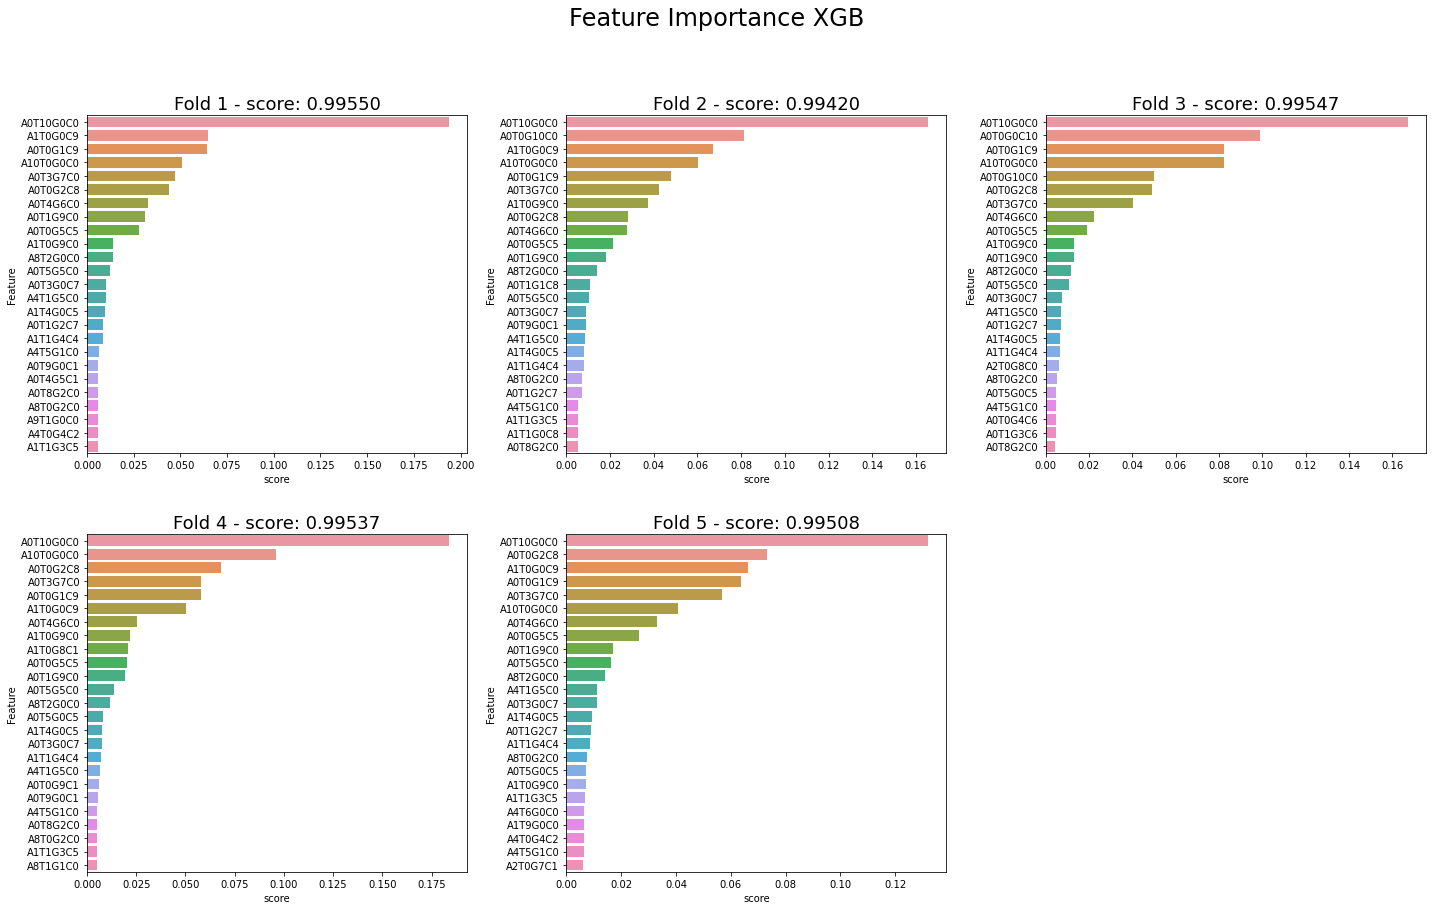

In [50]:

plt.figure(figsize=(20,12))
for fold, col in enumerate(feature_imp.filter(regex=r'fold').columns):            
    col_acc = 'acc_' + str(fold+1)
    df_fi = feature_imp.sort_values(by=col, ascending=False).reset_index().iloc[:25]
    df_fi = df_fi[['index', col, col_acc]]
    df_fi.columns = ['Feature', 'score', col_acc]
    plt.subplot(2,3, fold+1)
    sns.barplot(x='score', y='Feature', data=df_fi)    
    plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
              fontdict={'fontsize':18})    

plt.suptitle('Feature Importance XGB', y=1.05, fontsize=24);
plt.tight_layout(h_pad=3.0); 

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
    
    
</div>

### 3.1.1. Erro e  número de Estimadores

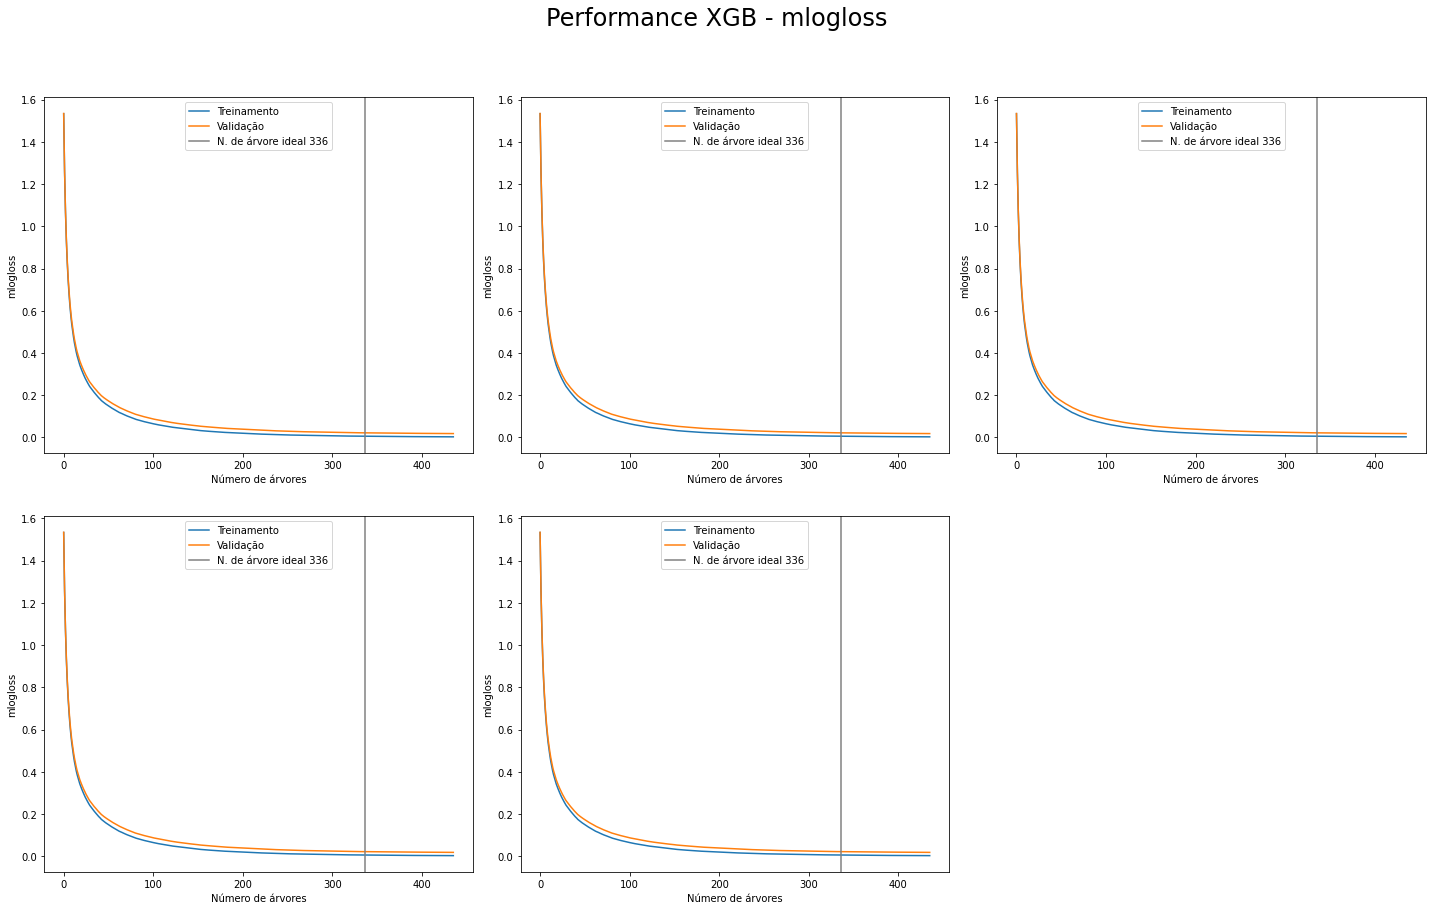

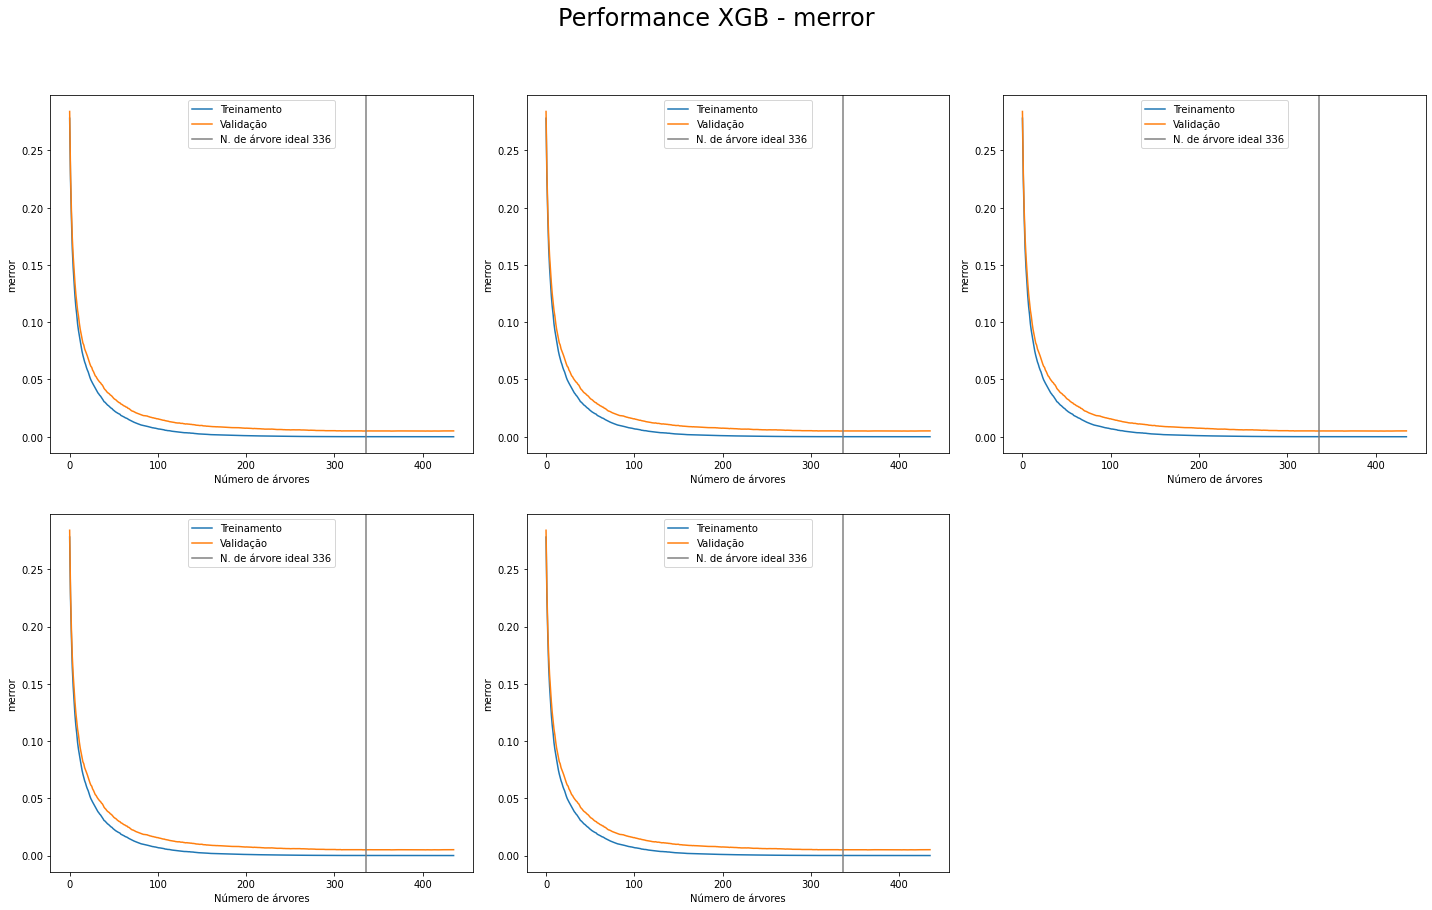

In [51]:
for erro in eval_metric:
    plt.figure(figsize=(20,12))

    for i in range(len(model)):
        results     = model[i]['model'].evals_result() # merror
        ntree_limit = model[i]['model'].best_ntree_limit

        plt.subplot(2,3,i+1)
        plt.plot(results["validation_0"][erro], label="Treinamento")
        plt.plot(results["validation_1"][erro], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))

        plt.xlabel("Número de árvores")
        plt.ylabel(erro)
        plt.legend();

    plt.suptitle('Performance XGB - {}'.format(erro), y=1.05, fontsize=24);
    plt.tight_layout(h_pad=3.0);

<div class="alert alert-info" role="alert"> 
    
**`NOTA:`** <br>
Acima recuperamos as informações de treinamento do nosso modelo, podemos observar que o número de 1000 estimadores é mais que suficiente para o treinamento do modelo, o ideal é que fique em entre de 300 à 350 para esses dados e com a utilização dos parametros padrões que devem ser ajustados para o `XGBoost`. <br>
  

Os próximos passos são: <br>
- Feature Engineering
- Tuning de hyperparametros    
    
</div>